In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import tarfile
import lsst.daf.persistence as dafPersist

In [6]:
hitsDataDir = '/epyc/users/mrawls/premap2019/hits-dr1'
hitsFilename = 'HiTS_DR1_variables_DM-dataset-subset.fits'
hitsFilepath = os.path.join(hitsDataDir, hitsFilename)
hitsTable = fits.open(hitsFilepath)  # load data as an astropy fits thing
hitsDf = pd.DataFrame(hitsTable[1].data)  # turn data into a pandas dataframe
hitsDf.head()  # show us (print out) what the dataframe looks like

,ID,internalID,raMedian,decMedian,Variable_prob,Periodic_prob,DSCT_Prob,EB_Prob,ROTVAR_Prob,RRLYR_Prob,...,Rcs,Skew,SlottedA_length,SmallKurtosis,Std,StetsonK,StetsonK_AC,g-i,g-r,r-i
0,HiTS095611+020452,Blind15A_26_N1_1715_0146,149.048038,2.081381,0.523601,0.202651,NaN,NaN,NaN,NaN,...,0.246009,-0.584446,0.134705,2.100608,0.032812,0.773151,0.738233,2.859381,1.439736,1.419645
1,HiTS095645+021135,Blind15A_26_N1_0181_2093,149.190225,2.193068,0.564932,0.635018,0.400,0.100,0.375,0.125,...,0.119267,-0.133774,0.067353,-0.444997,0.123052,0.841553,0.815632,0.996040,0.769289,0.226751
2,HiTS095652+023537,Blind15A_26_S14_1446_0379,149.220445,2.593841,0.962477,0.635836,0.025,0.125,0.750,0.100,...,0.227995,-0.317121,0.269410,-0.008631,0.067782,0.849505,0.846981,1.911452,1.484048,0.427403
3,HiTS095702+023628,Blind15A_26_S14_1253_0945,149.261780,2.607883,0.532390,0.933333,0.550,0.225,0.050,0.175,...,0.179956,-0.288333,0.067353,-1.067079,0.181790,0.853063,0.754798,NaN,NaN,NaN
4,HiTS095726+015556,Blind15A_26_N8_1496_2317,149.361376,1.932343,0.972280,0.889344,0.050,0.175,0.625,0.150,...,0.269737,-0.035972,0.740878,-1.731678,0.089139,0.957841,0.948092,1.185192,0.894064,0.291128


In [14]:
print(len(hitsDf))
#hitsDf.columns

165


## This Week's Goals
1. Access HiTS light curve data and plot it for at least one variable object
2. Access LSST light curve data for the same object(s) and plot it, too

In [26]:
# Intermediate goal: get something like `Blind15A_40_S17_LC_50.tar.gz`
# from a row in the dataframe
testRow = hitsDf.iloc[0]
tok = testRow['internalID'].split('_')
print(tok)
field = '_'.join([tok[0], tok[1]])
print(field)
ccd = tok[2]
lightcurveTestFile = field + '_' + ccd + '_LC_50.tar.gz'
lightcurveTestPath = os.path.join(hitsDataDir, 'light_curves', field, ccd, lightcurveTestFile)
print(lightcurveTestPath)
tarball = tarfile.open(lightcurveTestPath)
test = tarball.extractfile(testRow['internalID'] + '_g.dat')
dfl = pd.read_csv(test, sep='\t')
dfl.head()

['Blind15A', '26', 'N1', '1715', '0146']
Blind15A_26
/epyc/users/mrawls/premap2019/hits-dr1/light_curves/Blind15A_26/N1/Blind15A_26_N1_LC_50.tar.gz


,# EPOCH,MJD,MAG_KRON,MAGERR_KRON,MAG_AP1,MAGERR_AP1,MAG_AP2,MAGERR_AP2,MAG_AP3,MAGERR_AP3,MAG_AP4,MAGERR_AP4,MAG_AP5,MAGERR_AP5
0,2,57070.140676,18.754295,0.011075,18.632438,0.087301,18.647924,0.056074,18.652090,0.016748,18.656113,0.017532,18.666673,0.021142
1,3,57070.226286,18.776433,0.009337,18.666263,0.232865,18.666702,0.088676,18.671231,0.033621,18.668104,0.017540,18.671857,0.017544
2,4,57070.294917,18.763921,0.011913,18.694875,0.086042,18.670033,0.048765,18.673597,0.016502,18.670568,0.016741,18.673934,0.020216
3,5,57070.341931,18.763705,0.011295,18.680066,0.055696,18.667972,0.055054,18.670424,0.024224,18.672405,0.017030,18.679769,0.020277
4,6,57071.069643,18.770205,0.013549,18.627784,0.067997,18.665590,0.059297,18.676768,0.019339,18.679747,0.019302,18.702438,0.020977


In [43]:
def plot_hits(row, lcPath='/epyc/users/mrawls/premap2019/hits-dr1/light_curves'):
    '''Plots light curves from HiTS DR1.
    
    Parameters
    ----------
    row : Pandas Dataframe row from DR1 source data
    lcPath : Path on disk to light curves from DR1
    '''
    tok = row['internalID'].split('_')
    field = '_'.join([tok[0], tok[1]])
    ccd = tok[2]
    lightcurveFile = field + '_' + ccd + '_LC_50.tar.gz'
    tarball = tarfile.open(os.path.join(lcPath, field, ccd, lightcurveFile))
    data = tarball.extractfile(row['internalID'] + '_g.dat')
    dfl = pd.read_csv(data, sep='\t')  # load a file with light curve data into a pandas dataframe
    fig = plt.figure(figsize=(6, 4))
    plt.errorbar(dfl.MJD, dfl.MAG_AP1, dfl.MAGERR_AP1, marker='o', linestyle=':')
    plt.xlabel('Time (MJD)')
    plt.ylabel('magnitude')
    print(lightcurveFile)
    print(row['internalID'] + '_g.dat')

Blind15A_26_S14_LC_50.tar.gz
Blind15A_26_S14_1446_0379_g.dat


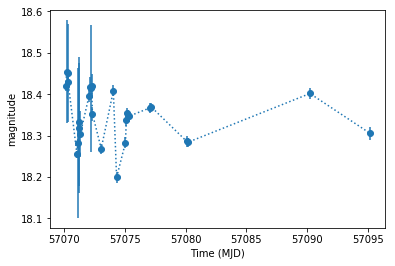

In [46]:
plot_hits(hitsDf.iloc[2])

We made it through part 1 of our goals! We have a function we can use to plot any of the 165 HiTS DR1 variable object light curves. We'll pick up from here next time to do part 2 of our goals.

Meredith made a demo notebook instead of updating this one for Nov 22!